In [1]:
import json
import os
from scene_objects import Scene_Objects
from collections import defaultdict

data_dir = "/home/mary/Code/spatial-reasoning/custom_clevr/output/scenes/"
scene_file = "CLEVR_train_000000.json"
output_dir = "/home/mary/Code/spatial-reasoning/relations/"

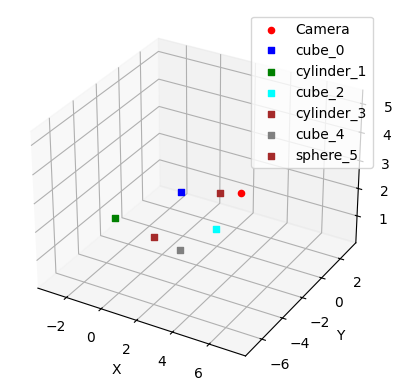

In [2]:
with open(os.path.join(data_dir, scene_file)) as data:
    scene_data = json.load(data)

scene_info = Scene_Objects(scene_data)
entities = scene_info.all_entities

In [3]:
# sentence = "The object that is between the green and the gray objects"
# e_1 = {'label': 'object', 'type':'target'}
# e_2 = {'label': 'object', 'color': 'green', 'type':'lm'}
# e_3 = {'label': 'object', 'color': 'gray', 'type':'lm'}
# obj_mentions = [e_1, e_2, e_3]
inverse_relations = {'right':'left', 'front': 'behind', 'left':'right', 'behind': 'front'}
relation_directions = {'left':[1, 1], 'right':[1, -1], 'front':[0, -1], 'behind':[0, 1]} #, 'above':[], 'below':[]}

In [4]:
sentence = "The object to the left of the sphere and behind the brown objects"
e_1 = {'label': 'object', 'type': 'target'}
e_2 = {'label': 'sphere', 'type': 'lm'}
e_3 = {'label': 'objects', 'color':'brown', 'type': 'lm_set'}
obj_mentions = [e_1, e_2, e_3]
r_1 = {'o1': 1, 'o2': 2, 'label': 'left'}
r_2 =  {'o1': 1, 'o2': 3, 'label':'behind'}
rel_mentions = [r_1, r_2]
mentions = {'objects': obj_mentions, 'relations': rel_mentions}


In [5]:
# a mention may be a set of objects with a shared label
# this is indicated by 'lm_set' above
# this set is stored under a shared index, associating it with a single mention

def initial_grounding(mentions):
    obj_mentions = mentions['objects']
    grounded = defaultdict(list)
    ungrounded = defaultdict(list)

    for i, obj in enumerate(obj_mentions): 
        found = False
        for entity in entities:
            features = [entity.shape, entity.color]
            if obj['label'] in features:
                grounded[i+1].append(entity)
                found = True
            elif 'color' in obj.keys():
                if obj['color'] in features:
                    grounded[i+1].append(entity)
                    found = True
        if found == False:
            ungrounded[i+1].append(entity)
                    
    return dict(grounded), dict(ungrounded)

In [6]:
grounded, ungrounded = initial_grounding(mentions)
print(grounded)
print(ungrounded)

{2: [<scene_objects.Entity object at 0x7f05bc1c9ac0>], 3: [<scene_objects.Entity object at 0x7f05bc1c9a60>, <scene_objects.Entity object at 0x7f05bc1c9ac0>]}
{1: [<scene_objects.Entity object at 0x7f05bc1c9ac0>]}


In [7]:
# if there is at least one ungrounded object in a mention, and one grounded object:
# we can start by finding objects that satisfy these pairs 
# pairs are directed, so we have to invert pairs that begin with an ungrounded obj

def relate(mentions, grounded):
    relations = mentions['relations']
    ug_relations = []
    qualifying_pairs = defaultdict(list)

    for relation in relations:
        o1 = relation['o1']
        o2 = relation['o2']
        relation_label = relation['label']
        if o1 not in grounded.keys():
            if o2 in grounded.keys():
                o1, o2 = o2, o1
                o1_entities = grounded[o1]
                for obj in o1_entities:
                    inverse_label = inverse_relations[relation_label]
                    qualifying_pairs[o1].append(evaluate_pairs(obj, inverse_label))
            else:
                ug_relations.append(relation)
        else:
            for obj in o1_entities:
                qualifying_pairs[o1].append(evaluate_pairs(obj, relation_label))
    return dict(qualifying_pairs)


def evaluate_pairs(o1, relation_label):
    relation_direction = relation_directions[relation_label]
    # get index of grounded object in the scene
    scene_obj_idx = o1.idx
    offsets = scene_info.obj_offsets
    obj_specific_pairs = offsets.get_obj_offsets(scene_obj_idx)
    matched_objs = {}
    
    for paired_obj in obj_specific_pairs.keys():
        dim = relation_direction[0]
        sign = relation_direction[1]
        offset = obj_specific_pairs[paired_obj]
        direction = offset['direction']
        
        if direction[dim] == sign:
            matched_objs[paired_obj] = offset
    
    return matched_objs

    



In [8]:
print(relate(mentions, grounded)[3])
e_2_groundings = relate(mentions, grounded)[2]
e_3_groundings = relate(mentions, grounded)[3]

for e in e_2_groundings:
    print(e.keys())
for e in e_3_groundings:
    print(e.keys())

[{0: {'distance': array([-1.11753812,  4.38833356,  0.        ]), 'direction': array([-1.,  1.,  0.]), 'xyz_offsets': [1.1175381243228912, -4.388333559036255, 0.0], 'theta_degrees': 15.424942648462682, 'theta_radians': 0.26921603614696804, 'cos_theta': 0.9639797079828473, 'sin_theta': 0.2659757932543947}, 1: {'distance': array([-2.67596129,  0.56011188,  0.        ]), 'direction': array([-1.,  1.,  0.]), 'xyz_offsets': [2.675961285829544, -0.5601118803024292, 0.0], 'theta_degrees': 6.969893603887036, 'theta_radians': 0.12164759190152223, 'cos_theta': 0.9926100515613181, 'sin_theta': 0.12134778753416739}}, {0: {'distance': array([-1.81048906, -0.91935158,  0.        ]), 'direction': array([-1., -1.,  0.]), 'xyz_offsets': [1.8104890584945679, 0.9193515777587891, 0.0], 'theta_degrees': 8.822803361020032, 'theta_radians': 0.1539869679058215, 'cos_theta': 0.9881674157772941, 'sin_theta': 0.15337913285719298}, 1: {'distance': array([-3.36891222, -4.74757326,  0.        ]), 'direction': array

[{1: {'distance': array([-4.48057151, -2.42648482,  0.34999999]), 'direction': array([-1., -1.,  1.]), 'xyz_offsets': [4.480571508407593, 2.4264848232269287, -0.3499999940395355], 'theta_degrees': 24.67323336441849, 'theta_radians': 0.43062915932202056, 'cos_theta': 0.9087032916376067, 'sin_theta': 0.41744260415891765}, 3: {'distance': array([-1.80461022, -2.9865967 ,  0.34999999]), 'direction': array([-1., -1.,  1.]), 'xyz_offsets': [1.8046102225780487, 2.986596703529358, -0.3499999940395355], 'theta_degrees': 19.40908025498115, 'theta_radians': 0.3387523552332416, 'cos_theta': 0.9431700050915995, 'sin_theta': 0.33231060996530354}, 4: {'distance': array([-0.53270209, -2.61459625,  0.        ]), 'direction': array([-1., -1.,  0.]), 'xyz_offsets': [0.5327020883560181, 2.6145962476730347, 0.0], 'theta_degrees': 13.503340610892874, 'theta_radians': 0.23567775367834312, 'cos_theta': 0.9723563077925709, 'sin_theta': 0.2335020571558186}}, {0: {'distance': array([-1.11753812,  4.38833356,  0.        ]), 'direction': array([-1.,  1.,  0.]), 'xyz_offsets': [1.1175381243228912, -4.388333559036255, 0.0], 'theta_degrees': 15.424942648462682, 'theta_radians': 0.26921603614696804, 'cos_theta': 0.9639797079828473, 'sin_theta': 0.2659757932543947}, 1: {'distance': array([-2.67596129,  0.56011188,  0.        ]), 'direction': array([-1.,  1.,  0.]), 'xyz_offsets': [2.675961285829544, -0.5601118803024292, 0.0], 'theta_degrees': 6.969893603887036, 'theta_radians': 0.12164759190152223, 'cos_theta': 0.9926100515613181, 'sin_theta': 0.12134778753416739}}]
